In [1]:
!pip install comet_ml

In [0]:
from comet_ml import Experiment

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [0]:
PARTICLES = ['kaon', 'pion', 'proton', 'muon']
MODEL_NAME = "Pytorch_Cramer_All_1layer"

In [4]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import scipy
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/rich_utils')

In [0]:
import torch_utils_rich_mrartemev as utils_rich

## Data

In [8]:
data_train, data_val, scaler = utils_rich.get_all_particles_dataset(dtype=np.float32, log=True, list_particles=PARTICLES)

Reading and concatenating datasets:
	../content/drive/My Drive/data/data_calibsample/kaon2_-_down_2016_.csv
	../content/drive/My Drive/data/data_calibsample/kaon2_+_down_2016_.csv
	../content/drive/My Drive/data/data_calibsample/kaon2_-_up_2016_.csv
	../content/drive/My Drive/data/data_calibsample/kaon2_+_up_2016_.csv
	../content/drive/My Drive/data/data_calibsample/kaon_-_down_2016_.csv
	../content/drive/My Drive/data/data_calibsample/kaon_+_down_2016_.csv
	../content/drive/My Drive/data/data_calibsample/kaon_-_up_2016_.csv
	../content/drive/My Drive/data/data_calibsample/kaon_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.047675609588623
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
Reading and concatenating datasets:
	../content/drive/My Drive/data/data_calibsample/pion2_-_down_2016_.csv
	../content/drive/My Drive/data/data_calibsample/pion2_+_down_2016_.csv
	../con

In [9]:
data_train.head()

,RichDLLe,RichDLLk,RichDLLmu,RichDLLp,RichDLLbt,is_kaon,is_pion,is_proton,is_muon,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight
0,0.555870,-0.944576,0.475479,-0.262760,-0.582201,1.0,0.0,0.0,0.0,0.244609,1.492709,0.087418,0.053932
1,-0.652621,0.301450,-0.531307,0.127719,0.039667,1.0,0.0,0.0,0.0,-0.014767,-0.691638,0.242183,1.166070
2,-0.705267,-2.879602,1.047932,-2.919171,-2.916759,1.0,0.0,0.0,0.0,-0.385698,-1.125975,-0.000664,-0.131609
3,1.397504,0.254146,1.027402,0.534375,0.443554,1.0,0.0,0.0,0.0,-0.641499,0.296501,-0.572245,0.433815
4,-1.019068,-0.465702,-0.683660,-0.029843,-0.140166,1.0,0.0,0.0,0.0,-0.395374,-0.716438,1.162377,1.265090


In [0]:
BATCH_SIZE = int(1e3)
LATENT_DIMENSIONS = 64

N_VAL = int(3e5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
from itertools import repeat

class ParticleSetTrain(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, ind):
        return (self.data[ind, utils_rich.y_count:-1], # X
                self.data[ind, -1], # Weight
                self.data[ind, :utils_rich.y_count], # DLL
                np.argmax(self.data[ind, utils_rich.y_count:utils_rich.y_count + len(PARTICLES)])
               )

class ParticleSet(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, ind):
        return (self.data[ind, utils_rich.y_count:-1], # X
                self.data[ind, -1], # Weight
                self.data[ind, :utils_rich.y_count] # DLL
               )
    
def repeater(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data
    
# https://github.com/pytorch/pytorch/issues/5398
# https://discuss.pytorch.org/t/implementing-an-infinite-loop-dataset-dataloader-combo/35567
train_loader = repeater(torch.utils.data.DataLoader(ParticleSetTrain(data_train.values),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    pin_memory=True))

validation_set = {particle: repeater(torch.utils.data.DataLoader(ParticleSet(data_val[data_val['is_{}'.format(particle)] == 1].values),
                                                  batch_size=N_VAL,
                                                  shuffle=False,
                                                  pin_memory=True)) for particle in PARTICLES}

In [49]:
for i in next(validation_set['kaon']):
    print(i.shape)

torch.Size([300000, 7])
torch.Size([300000])
torch.Size([300000, 5])


## Model

In [0]:
CRAMER_DIM = 256
NUM_LAYERS = 5

def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)

class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIMENSIONS + data_train.shape[1] - 1 - utils_rich.y_count, hidden_size),
            nn.LeakyReLU(0.05),
            *[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(0.05)) for _ in range(depth)],
            nn.Linear(hidden_size, utils_rich.y_count),
        )

    def forward(self, x, noise=None):
        return self.layers(torch.cat([x, get_noise(x.shape[0])], dim=1))

    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(data_train.shape[1] - 1, hidden_size),
            nn.LeakyReLU(0.05),
            *[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(0.05)) for _ in range(depth)],
        )
        self.out = nn.Sequential(nn.Linear(hidden_size, CRAMER_DIM))
        self.aux_layer = nn.Sequential(nn.Linear(hidden_size, utils_rich.y_count), nn.Softmax())

    def forward(self, x):
        res = self.layers(x)
        out = self.out(res)
        label = self.aux_layer(res)
        return out, label

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [0]:
netG = Generator(depth=NUM_LAYERS).to(device)
netG.apply(init_weights)

netC = Critic(depth=NUM_LAYERS).to(device)
netC.apply(init_weights)

pass

In [14]:
device

'cuda'

In [0]:
import itertools
optQ = torch.optim.AdamW(itertools.chain(netG.parameters(), netC.parameters()))
lr_Q = torch.optim.lr_scheduler.ExponentialLR(optimizer=optQ, gamma=0.995)

In [0]:
optC = torch.optim.AdamW(netC.parameters())
lr_C = torch.optim.lr_scheduler.ExponentialLR(optimizer=optC, gamma=0.995)
optG = torch.optim.AdamW(netG.parameters())
lr_G = torch.optim.lr_scheduler.ExponentialLR(optimizer=optG, gamma=0.995)

## Train

In [0]:
LOGDIR = "/content/drive/My Drive/"
logdir = '/content/drive/My Drive/torch_model.pt'

CRITIC_ITERATIONS_CONST = 15
TOTAL_ITERATIONS = int(5e4)
VALIDATION_INTERVAL = 1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


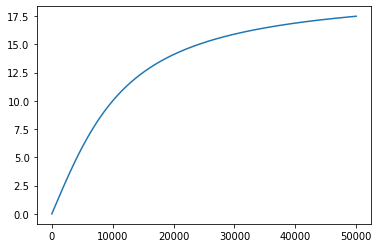

In [18]:
lambda_pt = lambda i: 20 / np.pi * 2 * torch.atan(torch.tensor(i, dtype=torch.float32, device=device)/1e4)

pt = []
for i in tqdm_notebook(range(50000)):
    pt.append(lambda_pt(i))
    
plt.plot(pt)

In [50]:
for i in next(train_loader):
    print(i.shape)

torch.Size([1000, 7])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])


In [20]:
experiment = Experiment(api_key="k62CZajG08ctPlNYUYRv9YVdO",
                        project_name="rich", workspace="nzinci")


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/nzinci/rich/9cb4f9e6a366426ab932b524c962b249



In [0]:
def calc_gradient_penalty(real_data, fake_data, fake_data2):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    
#     interpolates = torch.Tensor(interpolates, requires_grad=True)

    disc_interpolates = cramer_critic(interpolates, fake_data2)

    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    # create_graph=True, retain_graph=True, only_inputs=True - crucial for our case

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [0]:
def cramer_critic(x, y):
    discriminated_x, _ = netC(x)
    return torch.norm(discriminated_x - netC(y), dim=1) - torch.norm(discriminated_x, dim=1)

In [0]:
#Load Model
checkpoint = torch.load(logdir)
netC.load_state_dict(checkpoint[MODEL_NAME+'netC_state_dict'])
netG.load_state_dict(checkpoint[MODEL_NAME+'netG_state_dict'])
optC.load_state_dict(checkpoint[MODEL_NAME+'optC_state_dict'])
optG.load_state_dict(checkpoint[MODEL_NAME+'optG_state_dict'])
lr_C.load_state_dict(checkpoint[MODEL_NAME+'lr_C_state_dict'])
lr_G.load_state_dict(checkpoint[MODEL_NAME+'lr_G_state_dict'])

netC.eval()
netG.eval()

In [0]:
cat_loss = torch.nn.CrossEntropyLoss()
lambda_cat = 1
lambda_con = 0.1

particle: kaon, epoch: 4500


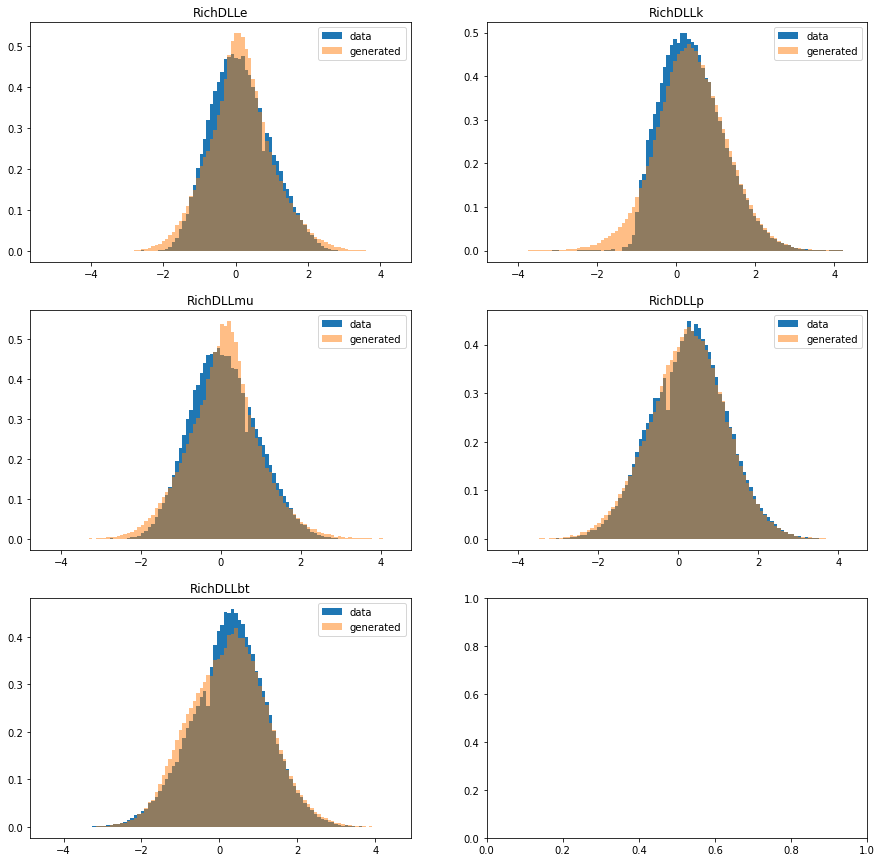

particle: pion, epoch: 4500


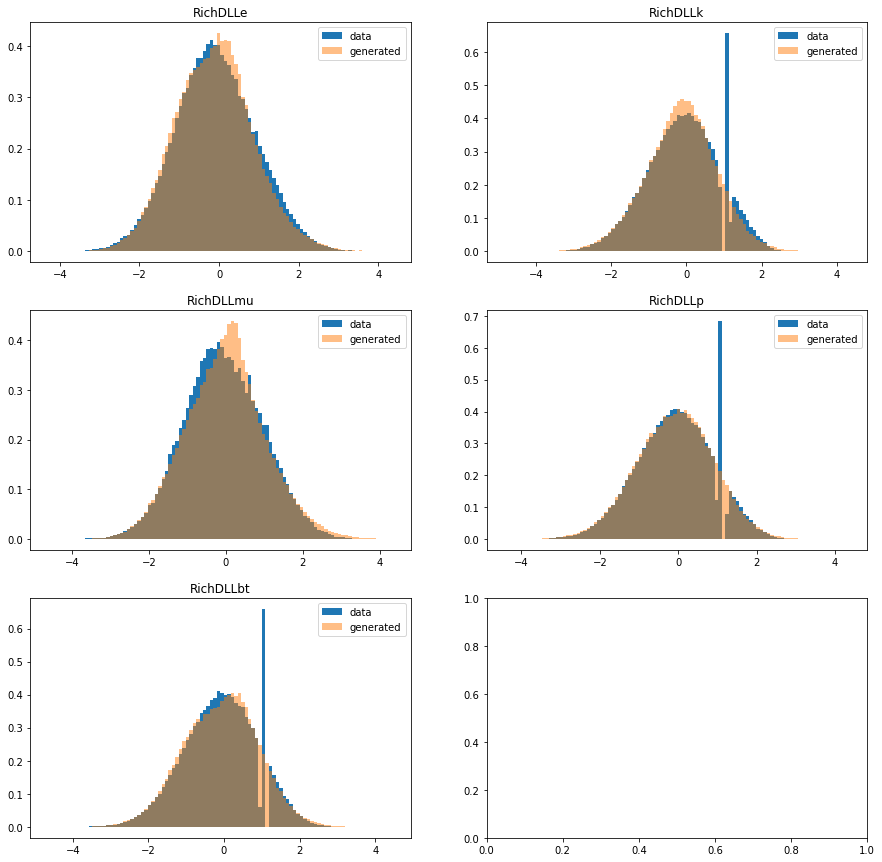

particle: proton, epoch: 4500


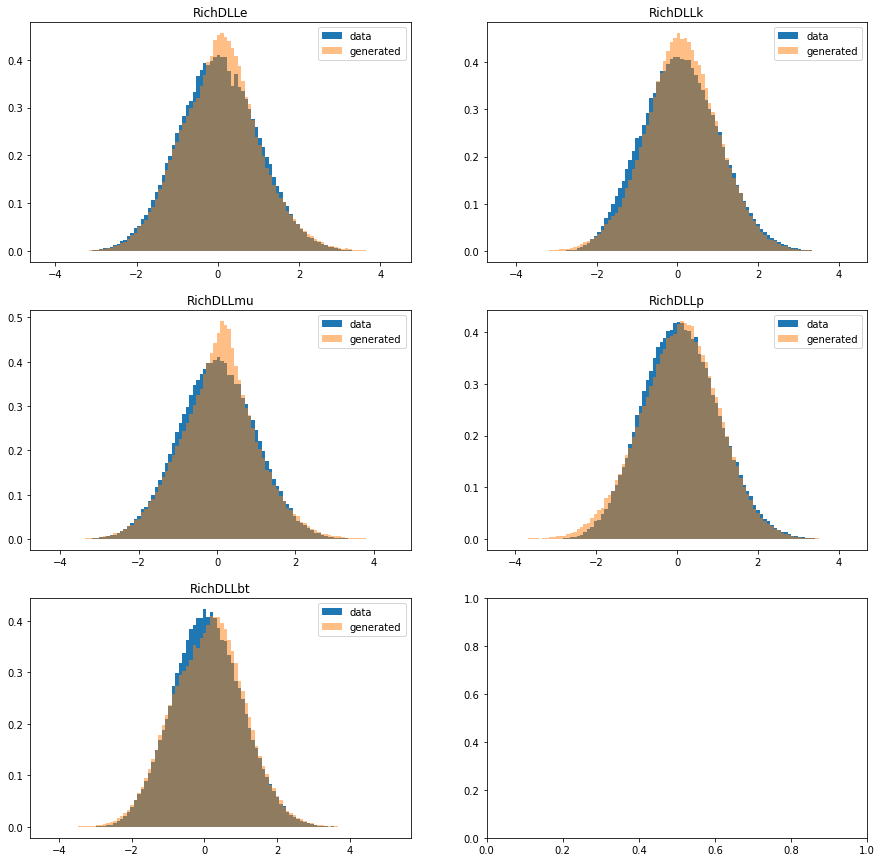

particle: muon, epoch: 4500


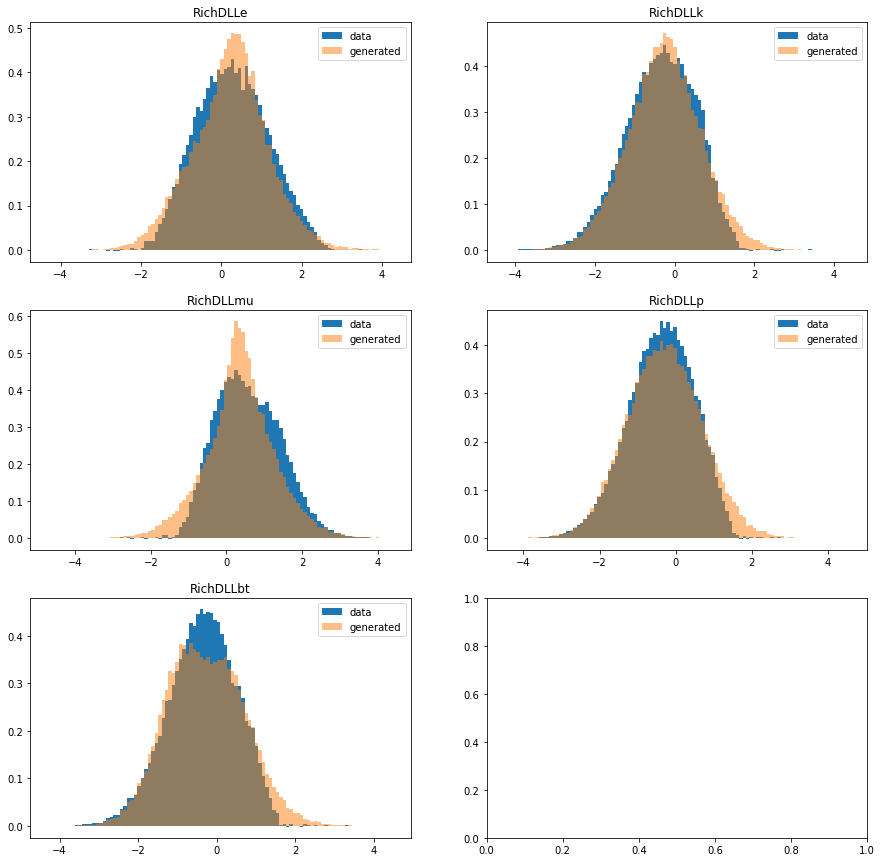

  1%|          | 4507/500000 [1:29:23<299:31:09,  2.18s/it]

KeyboardInterrupt: ignored

In [23]:
for iteration in tqdm(range(10*TOTAL_ITERATIONS), position=0, leave=True):
    # ---- Critic Train ----
    for critic_iter in range(CRITIC_ITERATIONS_CONST):
        x, weight, dlls, labels = [i.to(device) for i in next(train_loader)]
        
        optC.zero_grad()
        
        netG.eval()
        netC.train()
        
        real_full_0 = torch.cat([dlls, x], dim=1)    
        generated_1 = torch.cat([netG(x), x], dim=1)
        generated_2 = torch.cat([netG(x), x], dim=1)
        
        generator_loss = torch.mean(cramer_critic(real_full_0, generated_2) * weight - 
                                    cramer_critic(generated_1, generated_2) * weight)
        
        # GP
        gradient_penalty = calc_gradient_penalty(real_full_0, generated_1, generated_2)
        
        critic_loss = lambda_pt(iteration) * gradient_penalty - generator_loss
        critic_loss.backward()
        optC.step()

    # ---- Generator Train ----    
    x, weight, dlls, labels = [i.to(device) for i in next(train_loader)]
    
    netC.eval()
    netG.train()
    
    optG.zero_grad()
    real_full_0 = torch.cat([dlls, x], dim=1)
    generated_1 = torch.cat([netG(x), x], dim=1)
    generated_2 = torch.cat([netG(x), x], dim=1)

    generator_loss = torch.mean(cramer_critic(real_full_0, generated_2) * weight -
                cramer_critic(generated_1, generated_2) * weight)
    
    generator_loss.backward()
    optG.step()
    
    # ---- Info Train ----
    x, weight, dlls, tr_labels = [i.to(device) for i in next(train_loader)]

    netC.eval()
    netG.eval()
    real_full_0 = torch.cat([dlls, x], dim=1)
    generated_1 = torch.cat([netG(x), x], dim=1)
    generated_2 = torch.cat([netG(x), x], dim=1)
    _, pred_label = netC(generated_1)
    info_loss = lambda_con * torch.mean(cramer_critic(real_full_0, generated_2) * weight -
                cramer_critic(generated_1, generated_2) * weight) + lambda_cat * cat_loss(pred_label, tr_labels)

    info_loss.backward()
    optQ.step()
    
    experiment.log_metrics({'Generator loss': generator_loss.item(),
                            'Critic loss': critic_loss.item(),
                            'Info loss': info_loss.item()},
                            step=iteration)
    
    lr_Q.step()
    lr_C.step()
    lr_G.step()
    
    if iteration % 100 == 0:
        clear_output(False)
        for ind, particle in enumerate(PARTICLES):
            print('particle: {}, epoch: {}'.format(particle, iteration))
            with torch.no_grad():
                x, weight, dlls = [i.to(device) for i in next(validation_set[particle])]
                real_full = torch.cat([dlls, x], dim=1)

                generated = netG(x)
                fig, axes = plt.subplots(3, 2, figsize=(15, 15))
                for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
                    _, bins, _ = ax.hist(dlls[:, INDEX].cpu(),
                                        bins=100,
                                        label="data",
                                        density=True,
                                        weights=weight.cpu())
                    ax.hist(generated[:, INDEX].cpu(),
                            bins=bins,
                            label="generated",
                            alpha=0.5,
                            density=True,
                            weights=weight.cpu())
                    ax.legend()
                    ax.set_title(utils_rich.dll_columns[INDEX])
                experiment.log_figure()
                plt.show()
experiment.end()

In [0]:
logdir = '/content/drive/My Drive/torch_model.pt'
torch.save({MODEL_NAME+'netC_state_dict': netC.state_dict(),
            MODEL_NAME+'netG_state_dict': netG.state_dict(),
            MODEL_NAME+'optC_state_dict': optC.state_dict(),
            MODEL_NAME+'optG_state_dict': optG.state_dict(),
            MODEL_NAME+'lr_C_state_dict': lr_C.state_dict(),
            MODEL_NAME+'lr_G_state_dict': lr_G.state_dict()
           }, logdir)
from sklearn.externals import joblib
os.makedirs('./preprocessors', exist_ok=True)
joblib.dump(scaler, os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['preprocessors/Pytorch_Cramer_All_1layer_preprocessor.pkl']

particle: kaon


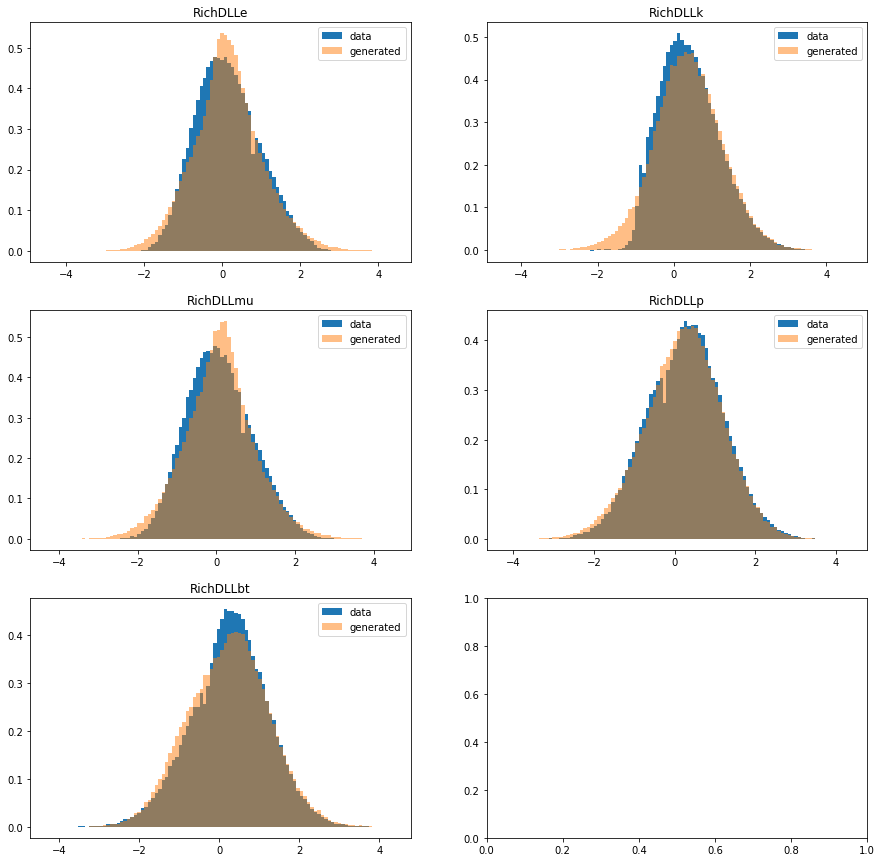

particle: pion


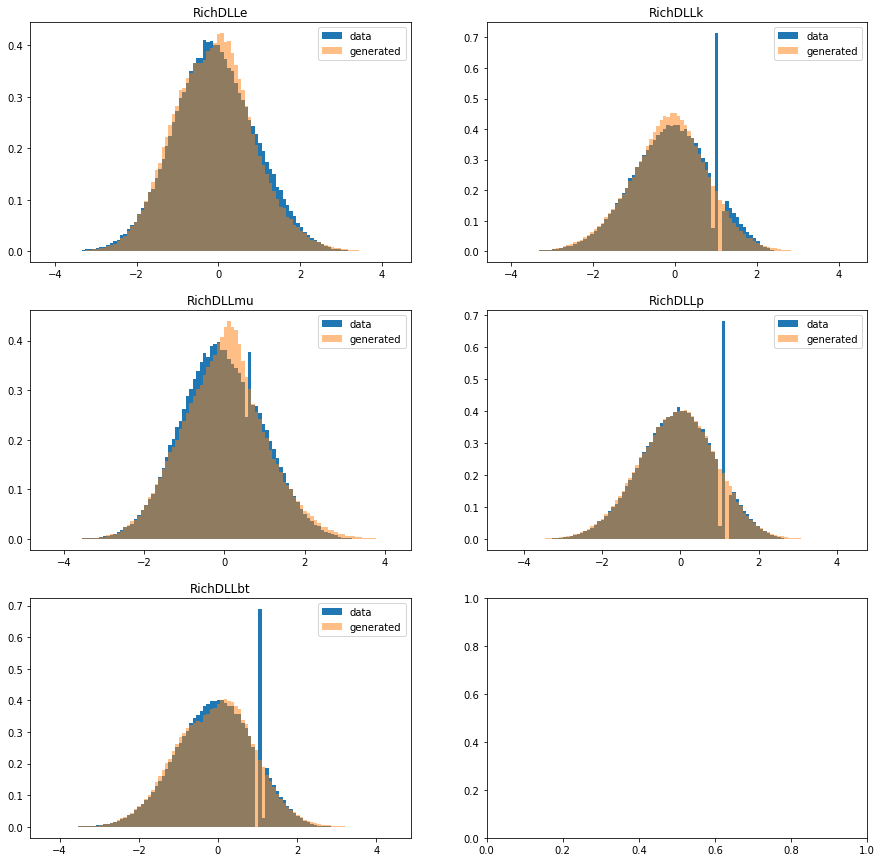

particle: proton


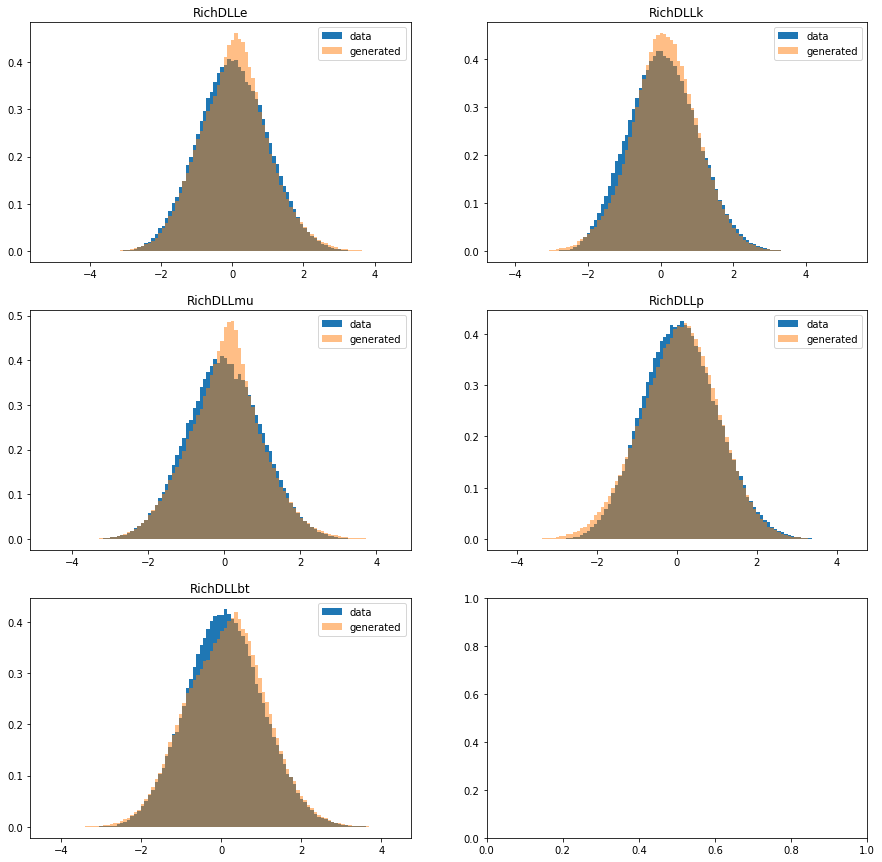

particle: muon


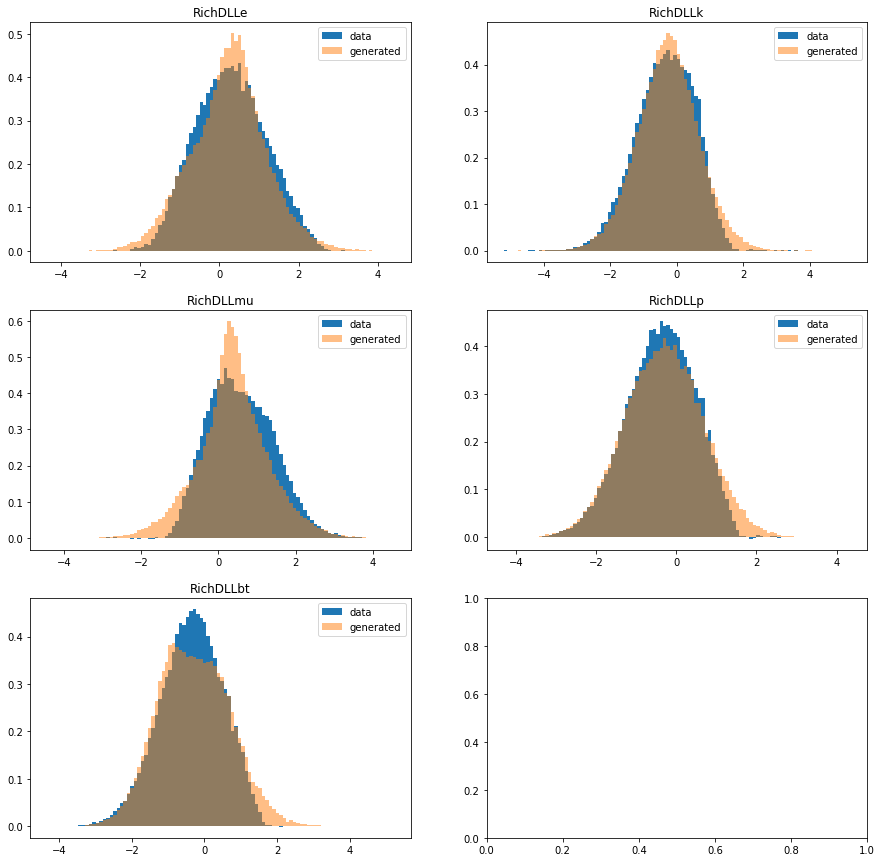

In [24]:
for ind, particle in enumerate(PARTICLES):
    print('particle: {}'.format(particle))
    with torch.no_grad():
        x, weight, dlls = [i.to(device) for i in next(validation_set[particle])]
        real_full = torch.cat([dlls, x], dim=1)

        generated = netG(x)
        fig, axes = plt.subplots(3, 2, figsize=(15, 15))
        for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
            _, bins, _ = ax.hist(dlls[:, INDEX].cpu(),
                                bins=100,
                                label="data",
                                density=True,
                                weights=weight.cpu())
            ax.hist(generated[:, INDEX].cpu(),
                    bins=bins,
                    label="generated",
                    alpha=0.5,
                    density=True,
                    weights=weight.cpu())
            ax.legend()
            ax.set_title(utils_rich.dll_columns[INDEX])
        plt.show()


In [25]:
from collections import defaultdict
eval_particles_loader = {particle: torch.utils.data.DataLoader(ParticleSet(
                                        data_val[data_val['is_{}'.format(particle)] == 1].values),
                                        batch_size=N_VAL,
                                        shuffle=False,
                                        pin_memory=True) for particle in PARTICLES}

particles_pred_dlls = defaultdict(list)
for particle in eval_particles_loader:
    for batch in tqdm(eval_particles_loader[particle], position=0, leave=True):
        x, weight, dlls = [i.to(device) for i in batch]
        particles_pred_dlls[particle].append(netG(x).detach().cpu().numpy())

100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


In [0]:
print(data_val.columns)

Index(['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt', 'is_kaon',
       'is_pion', 'is_proton', 'is_muon', 'Brunel_P', 'Brunel_ETA',
       'nTracks_Brunel', 'probe_sWeight'],
      dtype='object')


In [0]:
data_val_c = data_val.copy()

In [0]:
data_val_c = data_val_c.drop(['is_kaon', 'is_pion', 'is_proton', 'is_muon'], axis=1)

In [0]:
pred_data_inversed = {}
val_data_inversed = {}
for i, particle in enumerate(particles_pred_dlls):
    pred_dlls = np.concatenate(particles_pred_dlls[particle], axis=0)
    pred_data = np.concatenate([pred_dlls, data_val_c[data_val['is_{}'.format(
                                        particle)] == 1].values[:, utils_rich.y_count:-1]], axis=1)
    pred_data_inversed[particle] = scaler[i].inverse_transform(pred_data)
    val_data_inversed[particle] = scaler[i].inverse_transform(data_val_c[data_val['is_{}'.format(
                                        particle)] == 1].iloc[:, :-1])


In [0]:
val_data_inversed_ = {}
for particle in PARTICLES:
    val_data_inversed_[particle] = pd.DataFrame(val_data_inversed[particle], 
                                                columns=data_val_c.columns[:-1])
    for ind, col in enumerate(utils_rich.dll_columns):
        val_data_inversed_[particle]["predicted_"+col] = pred_data_inversed[particle][:, ind]
    val_data_inversed_[particle]['probe_sWeight'] = data_val_c[data_val['is_{}'.format(
                                        particle)] == 1]['probe_sWeight']


In [0]:
class Wrapper:
    def __init__(self, data):
        self.test = data

wrap = lambda x, particle: {particle: Wrapper(x)}

In [31]:
from model_testing import eval_model

particle_scores = []
for partcicle, vdata_inv in val_data_inversed_.items():
    scores, bins = eval_model(particle, wrap(vdata_inv, particle))
    particle_scores.append("Particle: {}, global test score: {} +- {}".format(particle,
                                                         scores.mean(axis=0)[0][1],
                                                         scores.std(axis=0)[0][1]))

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
100%|██████████| 3/3 [03:59<00:00, 79.68s/it]


In [32]:
for res in particle_scores:
    print(res)

Particle: muon, global test score: 0.9425840247954335 +- 0.0004571224784313148
Particle: muon, global test score: 0.9530139462216297 +- 0.0021743013284061252
Particle: muon, global test score: 0.9317572681917773 +- 0.0012139662342572272
Particle: muon, global test score: 0.939338645095674 +- 0.0012405153172763994
